In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans as KMeans
from sklearn.decomposition import SparsePCA
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgboost
from xgboost import XGBClassifier
from sklearn import tree
import graphviz

### Data processing
For features not specified at the species level, rename them to the genus level, then add the columns with the same name together to one column with the new name.

In [8]:
data = pd.read_csv('/Users/charlotte/Documents/UIUC Courses/stat542_fall/HW/Final Project/microbiome_542.csv')

/Users/charlotte/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (2,4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [9]:
data.shape

(9511, 32962)

In [10]:
# check the percentage of zeros in OTUs
data2 = data.iloc[:,8:32961]
ratio = []
for i in range(len(data2.columns)):
    temp = data2.iloc[:,i]
    ratio.append(sum(temp==0)/len(temp))
ratio = pd.DataFrame(ratio)
ratio.describe()

,0
count,32953.000000
mean,0.994163
std,0.039915
min,0.052360
25%,0.998949
50%,0.999474
75%,0.999790
max,0.999895


In [11]:
data3 = data.copy()
def helper(s):
    return s[:s.rfind('|')]
l = {s: helper(s) for s in data3.columns if  'unspecified' in s}                             

In [12]:
data3.rename(columns = l, inplace = True) 

In [13]:
data5 = data3.groupby(level=0, axis=1).sum()

In [14]:
data6 = data5.loc[:,['Unnamed: 0', 'age_cat', 'alcohol_frequency', 'bmi', 'bmi_cat','race',
       'sex', 'weight_kg']]
data7 = data5.loc[:,~data5.columns.isin(['Unnamed: 0', 'age_cat', 'alcohol_frequency', 'bmi', 'bmi_cat','race',
       'sex', 'weight_kg'])]

### Unsupervised learning
1. Hierarchy cluster

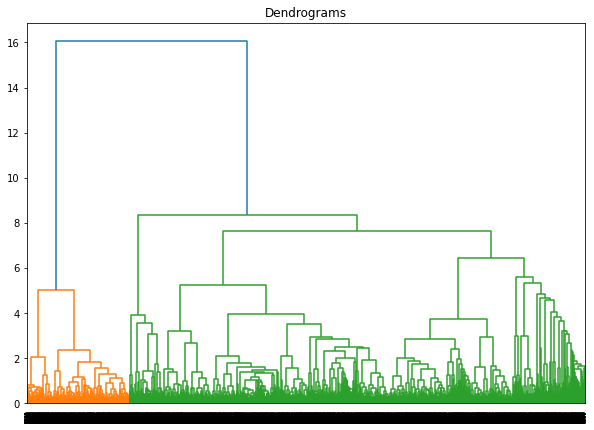

In [15]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data7, method='ward'))

2. KMeans cluster

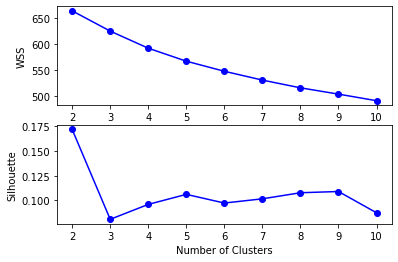

In [16]:
wss = []
sil = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init="k-means++",n_init=10,  max_iter=300,random_state=42)
    kmeans.fit(data7)
    wss.append(kmeans.inertia_)
    
    pre = kmeans.labels_
    sil.append(silhouette_score(data7, pre, metric = 'euclidean'))

plt.subplot(2,1,1)   
plt.plot(range(2, 11), wss, 'bo-')
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("WSS")

plt.subplot(2,1,2) 
plt.plot(range(2, 11), sil, 'bo-') 
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters") 
plt.ylabel('Silhouette') 
plt.show()

In [17]:
# select k value based on the above figure
kmeans_f = KMeans(n_clusters=2, init="k-means++",n_init=10,  max_iter=300,random_state=42)
kmeans_f.fit(data7)
pred_ = kmeans_f.labels_
[values, counts] = np.unique(pred_, return_counts=True)
kmeans_result = pd.DataFrame({'cluster': values+1, 'No. of samples': counts}, columns=['cluster', 'No. of samples'])
print(kmeans_result)

   cluster  No. of samples
0        1            6378
1        2            3133


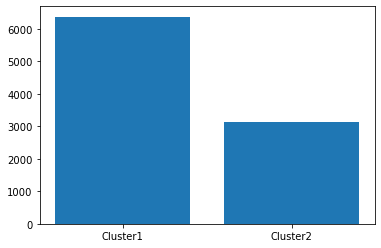

In [18]:
labels = ['Cluster1', 'Cluster2']
plt.bar(labels,counts)
plt.show()

3. Sparse PCA

In [19]:
spca = SparsePCA(alpha=0.001, n_components=10,ridge_alpha=1e-06)
spca.fit(data7)
t_spca = spca.transform(data7)
p_spca = spca.components_.T
t_spca_qr = np.linalg.qr(t_spca) 
r = t_spca_qr[1]
# compute adjusted variance
variance = []
for i in range(10):
    variance.append(np.square(r[i][i])/data7.shape[0])

total_variance_in_x = np.matrix.trace(np.cov(data7.T)) # Variance in the original dataset
variance = np.array(variance)/ total_variance_in_x
explained_variance_ratio = np.cumsum(variance)

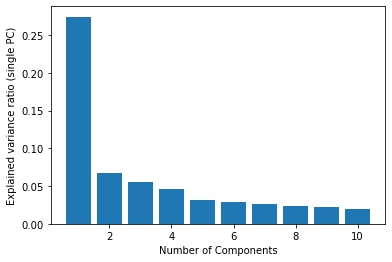

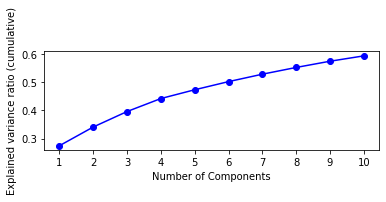

In [20]:
plt.subplot(1,1,1)  
plt.bar(range(1,11),variance)
plt.xlabel("Number of Components")
plt.ylabel("Explained variance ratio (single PC)")
plt.show()

plt.subplot(2,1,1)  
plt.plot(range(1, 11), explained_variance_ratio, 'bo-')
plt.xticks(range(1, 11))
plt.xlabel("Number of Components")
plt.ylabel("Explained variance ratio (cumulative)")
plt.show()

### Supervised learning — data preprocessing
#### Address missing data problem
For the missing values in the predictors, if the variable is categorical, we leave the missing values as they are; if the variables is numeric, we fill the missing values with the mean of the variable.
For response variables, BMI, BMI category and alcohol consumption frequency, we fill in the missing values based on the following rules: 

1. Missing values of BMI: calculate the mean BMI value associated with each value of alcohol consumption frequency, then fill in the missing values with mean value based on the corresponding alcohol consumption frequency value.

2. Missing values of BMI category: fill in based on the CDC published relationship between the value of BMI and BMI category.

3. Missing values of alcohol consumption frequency: first find the most frequent alcohol consumption frequency value associated with BMI category, then fill in the missing values based on the corresponding BMI category value.

4. For missing values we cannot fill in based on the above rulse, delete them.

#### End the classification of OTUs at the genus level

Since most features are not specified at the species level, we will ignore the species and only classify the OTU to the genus level. Thus, we rename all OTUs to the genus level, then add the columns with the same name together to one column with the new name.

#### Drop less frequent covariates

We will drop covariates that appear in less than 1% samples. To maintain the compositional nature of microbiome data, we will delete samples that do not satisfy the nature after dropping the covariates.

In [21]:
# fill missing data
bmi = data6['bmi']
bmi_cat = data6['bmi_cat']
alc = data6['alcohol_frequency']

bmi = bmi.replace('Not provided',-999999)
bmi = bmi.astype(float)
bmi2 = bmi[(bmi<5.0) | (bmi>190.0)]

y = pd.concat([bmi,bmi_cat,alc], axis=1)
y3 = y[(y['bmi']>0)&(y['bmi']<=190)&(y['bmi_cat']=='Not provided')&(y['alcohol_frequency']!='Not provided')]
s3 = y3['bmi'].groupby(y3['alcohol_frequency']).mean()
y2 = y[(y['bmi_cat']!='Not provided')&(y['alcohol_frequency']!='Not provided')]           
s4 = y2['alcohol_frequency'].groupby([y2['bmi_cat'],y2['alcohol_frequency']]).count().unstack().idxmax(axis =1).reset_index()
s4 = s4.set_index('bmi_cat')
s4 = s4.iloc[:,0]

for i in range(len(y)):
    temp1 = y.loc[i,'bmi']
    temp2 = y.loc[i,'bmi_cat']
    temp3 = y.loc[i,'alcohol_frequency']
    if ((temp1>190)|(temp1<0))& (temp3!='Not provided'):
        y.loc[i,'bmi'] = s3[temp3]
        y.loc[i,'bmi_cat'] = 'Normal'
    if (temp2!='Not provided')& (temp3=='Not provided'):
        y.loc[i,'alcohol_frequency'] = s4[temp2]
    if ((temp1<=190)|(temp1>0))&(temp2=='Not provided'):
        if temp1<18.5:
            y.loc[i,'bmi_cat'] = 'Underweight'
        elif ((temp1>=18.5)&(temp1<25)):
            y.loc[i,'bmi_cat'] = 'Normal'
        elif ((temp1>=25)&(temp1<30)):
            y.loc[i,'bmi_cat'] = 'Overweight'
        elif temp1>=30:
            y.loc[i,'bmi_cat'] = 'Obese'   
yy2 = y[(y['bmi_cat']=='Not provided')&(y['alcohol_frequency']=='Not provided')]

# delete samples that cannot be filled
data8 = data5.copy()
data8.drop(data8[(data8['bmi_cat']=='Not provided')&(data8['alcohol_frequency']=='Not provided')].index, inplace = True)

print(data8.shape)


(9378, 4114)


In [22]:
# end the classification of OTUs at the genus level
def helper2(s):
    return s[:s.rfind('|s__')]
l2 = {s: helper2(s) for s in data8.columns if  '|s__' in s}
data8.rename(columns = l2, inplace = True)
data9 = data8.groupby(level=0, axis=1).sum()
data9.loc[:,['bmi','bmi_cat','alcohol_frequency']] = y
data9.shape

(9378, 884)

In [32]:
# drop less frequent variables
temp = data9.loc[:,~data9.columns.isin(['Unnamed: 0', 'age_cat', 'alcohol_frequency', 'bmi', 'bmi_cat','race',
       'sex', 'weight_kg'])]
b = np.array((temp>0).sum())
ind = np.where(b>95)[0]
temp2 = temp.iloc[:,ind]
a = np.array(temp2.sum(axis=1))
ind2 = np.where(a>=0.999)[0]
temp3 = temp.iloc[ind2,ind]
temp5 = data9.loc[:,['Unnamed: 0', 'age_cat', 'alcohol_frequency', 'bmi', 'bmi_cat','race',
       'sex', 'weight_kg']]
temp4 = temp5.iloc[ind2,:]

data10 = pd.concat([temp4,temp3],axis=1)
data10.drop(data10[(data10['bmi_cat']=='Not provided')&(data10['alcohol_frequency']=='Not provided')].index, inplace = True)
data10.loc[data10['weight_kg']=='Not provided','weight_kg'] = pd.to_numeric(data10.loc[data10['weight_kg']!='Not provided','weight_kg'],downcast="float").mean()
data10.loc[:,'weight_kg'] = pd.to_numeric(data10.loc[:,'weight_kg'],downcast="float")
data10.shape

(7638, 237)

### Supervised learning — regression models
1. Lasso with constraint

In [37]:
# data transformation and train test split
temp1 = data10.loc[:,~data10.columns.isin(['Unnamed: 0', 'age_cat', 'alcohol_frequency', 'bmi', 'bmi_cat','race',
       'sex','weight_kg'])]
temp = (temp1+1)
temp2 = np.log(temp)

data10_1 = pd.concat([data10.loc[:,['age_cat', 'race','sex','weight_kg']],temp2],axis=1)
data10_1 = pd.get_dummies(data10_1)

x_train1, x_test1, y_bmi_train, y_bmi_test = train_test_split(data10_1, data10.loc[:,'bmi'], test_size=0.3, random_state=0)
x_test1_1, x_oft1, y_bmi_test1, y_bmi_oft1 = train_test_split(x_test1, y_bmi_test, test_size=0.1, random_state=0)

In [42]:
# lasso with constraint
def f(beta):
    return sum((x_train1.dot(beta)-y_bmi_train)**2)+lam*sum(beta)
beta0 = np.zeros([x_train1.shape[1],1])+1

residual = []
for lam in range(1,11,1):
    cons=({'type': 'eq',
           'fun': lambda beta: sum(beta)})
    res = minimize(f, beta0, constraints=cons)
    beta = res['x']
    y_bmi_pre = x_test1_1.dot(beta)
    c=beta
    coef_ind = np.where(abs(c)>0)[0]
    rms = mean_squared_error(y_bmi_test1, y_bmi_pre, squared=False)
    residual.append(rms)

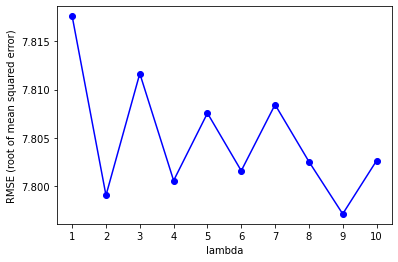

In [44]:
# model evaluation
plt.plot(range(1, 11), residual, 'bo-')
plt.xticks(range(1, 11))
plt.xlabel("lambda")
plt.ylabel("RMSE (root of mean squared error)")
plt.show()

In [46]:
# model prediction in out-of-time data
lam = 9
res = minimize(f, beta0, constraints=cons)
beta = res['x']
y_bmi_oft_pre = x_oft1.dot(beta)
rms_oft = mean_squared_error(y_bmi_oft1,y_bmi_oft_pre, squared=False)
print('The RMSE(root of mean square error) of Lasso with constraint is', rms)

The RMSE(root of mean square error) of Lasso with constraint is 7.802619646814919


2. Decision Tree Regression

In [47]:
# Another method for data transformation
temp = data10.loc[:,~data10.columns.isin(['Unnamed: 0', 'age_cat', 'alcohol_frequency', 'bmi', 'bmi_cat','race',
       'sex','weight_kg'])]
temp1 = (temp+1)
temp2 = temp1.div(temp1.iloc[:,temp1.shape[1]-1],axis=0)
temp3 = np.log(temp2)
data11 = pd.concat([data10.loc[:,['age_cat', 'race','sex','weight_kg']],temp3],axis=1)
data11 = pd.get_dummies(data11)

random.seed(542)
train_ind2 = random.sample(range(data11.shape[0]), int(data11.shape[0]*0.7))
x_train2 = data11.iloc[train_ind2,:]
x_test2 = data11.drop(data11.index[train_ind2])

test_ind = random.sample(range(x_test2.shape[0]), int(x_test2.shape[0]*0.2))
x_test2_1 = x_test2.iloc[test_ind,:]
x_test2_oft = x_test2.drop(x_test2.index[test_ind])

temp_y = data10.loc[:,'bmi']
y_bmi_train2 = temp_y.iloc[train_ind2]
y_bmi_test2 = temp_y.drop(temp_y.index[train_ind2])

y_bmi_test2_1 = y_bmi_test2.iloc[test_ind]
y_bmi_test2_oft = y_bmi_test2.drop(y_bmi_test2.index[test_ind])

temp_y1 = data10.loc[:,'bmi_cat']
y_bmi_cat_train = temp_y1.iloc[train_ind2]
y_bmi_cat_test = temp_y1.drop(temp_y1.index[train_ind2])

y_bmi_cat_test_1 = y_bmi_cat_test.iloc[test_ind]
y_bmi_cat_test_oft = y_bmi_cat_test.drop(y_bmi_cat_test.index[test_ind])

temp_y2 = data10.loc[:,'alcohol_frequency']
y_alc_train = temp_y2.iloc[train_ind2]
y_alc_test = temp_y2.drop(temp_y1.index[train_ind2])

y_alc_test_1 = y_alc_test.iloc[test_ind]
y_alc_test_oft = y_alc_test.drop(y_alc_test.index[test_ind])

In [57]:
# decision tree regression
rms2 = []
for i in range(5,16,1):
    regressor = DecisionTreeRegressor(random_state=0,max_depth = i)
    regressor.fit(x_train2,y_bmi_train2)
    y_bmi_pre2 = regressor.predict(x_test2_1) 
    rms2.append(mean_squared_error(y_bmi_test2_1, y_bmi_pre2, squared=False))

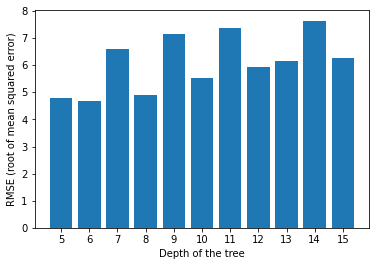

In [58]:
# model evaluation
plt.bar(range(5,16,1), rms2)
plt.xticks(range(5,16,1))
plt.xlabel("Depth of the tree")
plt.ylabel("RMSE (root of mean squared error)")
plt.show()

In [56]:
# model evaluation
regressor = DecisionTreeRegressor(random_state=0, max_depth = 6)
regressor.fit(x_train2,y_bmi_train2)
y_bmi_pre_oft2 = regressor.predict(x_test2_oft) 

rms_f = mean_squared_error(y_bmi_test2_oft, y_bmi_pre_oft2, squared=False)
print('The RMSE(root of mean square error) of decision tree regression is', rms_f)

The RMSE(root of mean square error) of decision tree regression is 8.203392205241437


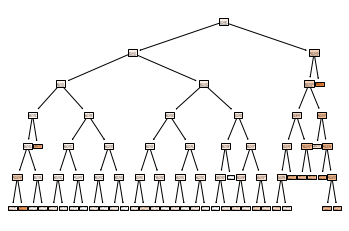

In [106]:
# plot
regressor = DecisionTreeRegressor(random_state=0, max_depth = 6)
regressor.fit(x_train2,y_bmi_train2)
_ = tree.plot_tree(regressor, filled=True)

### Supervised learning — classification models 
1. Logistic regression

In [59]:
# model to predict BMI category 
lr = LogisticRegression(C=0.1,solver='liblinear',random_state=10,penalty='l1')
lr.fit(x_train2, y_bmi_cat_train)
lr_pre_bmi_cat = lr.predict(x_test2)

# model evaluation
acc_lr = accuracy_score(y_bmi_cat_test, lr_pre_bmi_cat)
print('The accuracy of logistic regression for BMI category is', acc_lr)

The accuracy of logistic regression for BMI category is 0.6854275741710296


In [60]:
# model to predict alcohol consumption frequency
lr2 = LogisticRegression(C=0.1,solver='liblinear',random_state=10,penalty='l1')
lr2.fit(x_train2, y_alc_train)
lr2_pre_alc = lr2.predict(x_test2)

# model evaluation
acc_lr2 = accuracy_score(y_alc_test, lr2_pre_alc)
print('The accuracy of logistic regression for alcohol consumption frequency is', acc_lr2)

The accuracy of logistic regression for alcohol consumption frequency is 0.3254799301919721


2. Random Forest

In [65]:
# model to predict BMI category 
acc_rf = []
for i in range(100,1001,100):
    rf = RandomForestClassifier(n_estimators=i, random_state=10, max_depth=10, 
                                min_samples_split=0.01,
                                n_jobs=-1)

    rf.fit(x_train2, y_bmi_cat_train)
    rf_pre_bmi_cat = rf.predict(x_test2_1)
    acc_rf.append(accuracy_score(y_bmi_cat_test_1, rf_pre_bmi_cat))

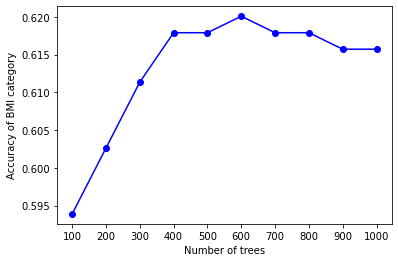

In [72]:
# model evaluation
plt.plot(range(100,1001,100), acc_rf, 'bo-')
plt.xticks(range(100,1001,100))
plt.xlabel("Number of trees")
plt.ylabel("Accuracy of BMI category")
plt.show()

In [70]:
# predict
rf = RandomForestClassifier(n_estimators=600, random_state=10, max_depth=10, 
                                min_samples_split=0.01,
                                n_jobs=-1)
rf.fit(x_train2, y_bmi_cat_train)
rf_pre_bmi_cat_oft = rf.predict(x_test2_oft)
acc_rf_f = accuracy_score(y_bmi_cat_test_oft, rf_pre_bmi_cat_oft)
print('The accuracy of random forest for BMI category  is', acc_rf_f)

The accuracy of random forest for BMI category  is 0.6046892039258451


In [79]:
# model to predict alcohol consumption frequency
acc_rf2 = []
for i in range(100,1001,100):
    rf2 = RandomForestClassifier(n_estimators=i, random_state=10, max_depth=10, 
                                min_samples_split=0.01,
                                n_jobs=-1)
    rf2.fit(x_train2, y_alc_train)
    rf2_pre_alc = rf2.predict(x_test2_1)
    acc_rf2.append(accuracy_score(y_alc_test_1, rf2_pre_alc))

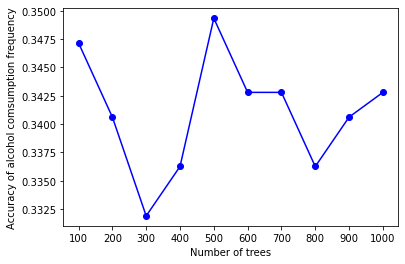

In [80]:
# model evaluation
plt.plot(range(100,1001,100), acc_rf2, 'bo-')
plt.xticks(range(100,1001,100))
plt.xlabel("Number of trees")
plt.ylabel("Accuracy of alcohol comsumption frequency")
plt.show()

In [81]:
# model evaluation
rf2 = RandomForestClassifier(n_estimators=500, random_state=10, max_depth=10, 
                            min_samples_split=0.01,
                            n_jobs=-1)
rf2.fit(x_train2, y_alc_train)
rf2_pre_alc_f = rf2.predict(x_test2_oft)
acc_rf2_f = accuracy_score(y_alc_test_oft, rf2_pre_alc_f)
print('The accuracy of random forest for alcohol consumption frequency is', acc_rf2_f)

The accuracy of random forest for alcohol consumption frequency is 0.3233369683751363


Text(0.5, 1.0, 'Feature importanct of Random Forest in BMI category')

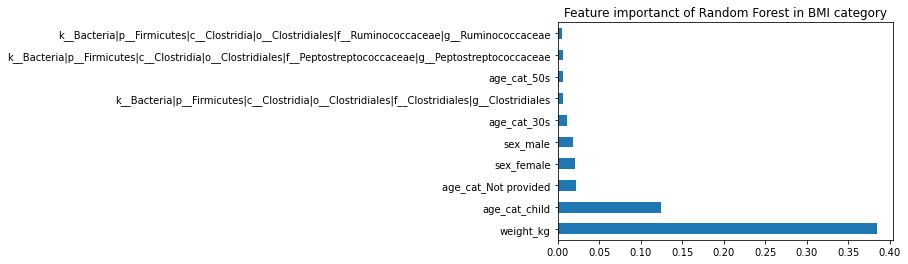

In [117]:
feat_importances_rf = pd.Series(rf.feature_importances_, index=x_train2.columns)
feat_importances_rf.nlargest(10).plot(kind='barh')
plt.title('Feature importanct of Random Forest in BMI category')

Text(0.5, 1.0, 'Feature importanct of Random Forest in alcohol consumption frequency')

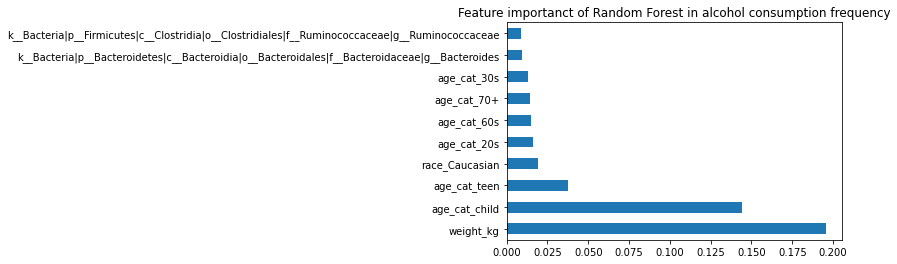

In [116]:
feat_importances_rf2 = pd.Series(rf2.feature_importances_, index=x_train2.columns)
feat_importances_rf2.nlargest(10).plot(kind='barh')
plt.title('Feature importanct of Random Forest in alcohol consumption frequency')

3. XGBoost

In [61]:
# model to predict BMI category 
xgb = XGBClassifier()
xgb.fit(x_train2, y_bmi_cat_train)
xgb_pre_bmi_cat = xgb.predict(x_test2)

# model evaluation
acc_xgb = accuracy_score(y_bmi_cat_test, xgb_pre_bmi_cat)
print('The accuracy of XGBoost for BMI category  is', acc_xgb)

The accuracy of XGBoost for BMI category  is 0.7460732984293194


In [63]:
# model to predict alcohol consumption frequency
xgb2 = XGBClassifier()
xgb2.fit(x_train2, y_alc_train)
xgb2_pre_acl = xgb2.predict(x_test2)

# model evaluation
acc_xgb2 = accuracy_score(y_alc_test, xgb2_pre_acl)
print('The accuracy of XGBoost for alcohol consumption frequency is', acc_xgb2)

The accuracy of XGBoost for alcohol consumption frequency is 0.28970331588132636


Text(0.5, 1.0, 'Feature importanct of XGBoost for BMI category')

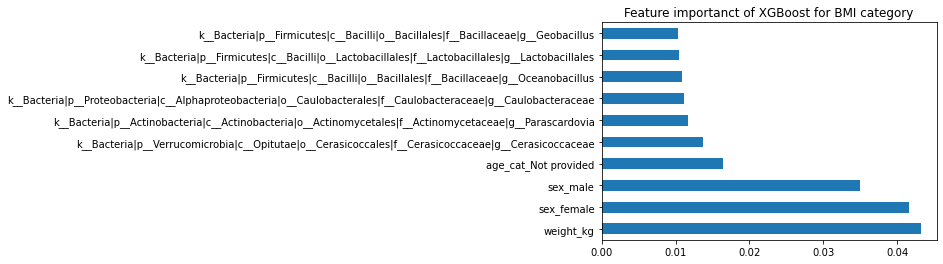

In [113]:
feat_importances_xgb = pd.Series(xgb.feature_importances_, index=x_train2.columns)
feat_importances_xgb.nlargest(10).plot(kind='barh')
plt.title('Feature importanct of XGBoost for BMI category')

Text(0.5, 1.0, 'Feature importanct of XGBoost for alcohol consumption frequency')

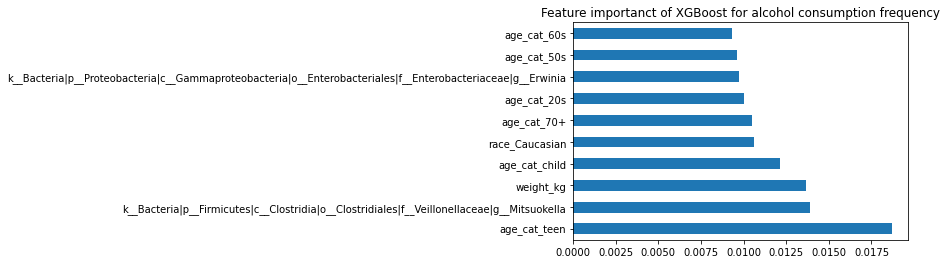

In [114]:
feat_importances_xgb2 = pd.Series(xgb2.feature_importances_, index=x_train2.columns)
feat_importances_xgb2.nlargest(10).plot(kind='barh')
plt.title('Feature importanct of XGBoost for alcohol consumption frequency')